In [ ]:
import os
import sys
cwd = os.getcwd()
source_path = os.path.join(cwd, '..')
print(source_path)
sys.path.append(source_path)

import logging
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import numpy as np
import dask.array as da
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from src import Data, Parameters, Pycro, DownloadData, SimpleCellposeSegmentaion, BIGFISH_SpotDetection, CellProperties, Save_Images, Save_Masks, Save_Outputs, Save_Parameters, remove_local_data, return_to_NAS


c:\Users\Jack\Documents\GitHub\AngelFISH\Demos\..


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


# Step 1) Pick a notebook from notebook and modify parameters

In [2]:
params = Parameters()
data = Data('Demo_Pipeline')

params.num_chunks_to_run = 2

In [3]:
params.load_in_mask = True
params.initial_data_location = [r"Users\Jack\_Datasets\IntronDiffusion\04032025_TriptolideTimeseries_FISH\JF001_0min_5uM_12"]
params.independent_params = {}

if data.images is None:
    params.local_dataset_location = DownloadData().main(**params.__dict__)['local_dataset_location']
    output = Pycro().main(**params.__dict__)
    data.append(output)

pp = data.images.shape[0]
tt = data.images.shape[1]
cc = data.images.shape[2]
zz = data.images.shape[3]
yy = data.images.shape[4]
xx = data.images.shape[5]

print(data)

Data(zarr_path=Demo_Pipeline, loaded=True, dataset_keys=['_zarr_path', '_ds', '_loaded', 'images', 'independent_params', 'position_indexs'])


INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)


Segmenting Nuclei


INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\nucleitorch_0
c:\Users\Jack\Documents\GitHub\AngelFISH\.venv\Lib\site-packages\cellpose\resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub fo

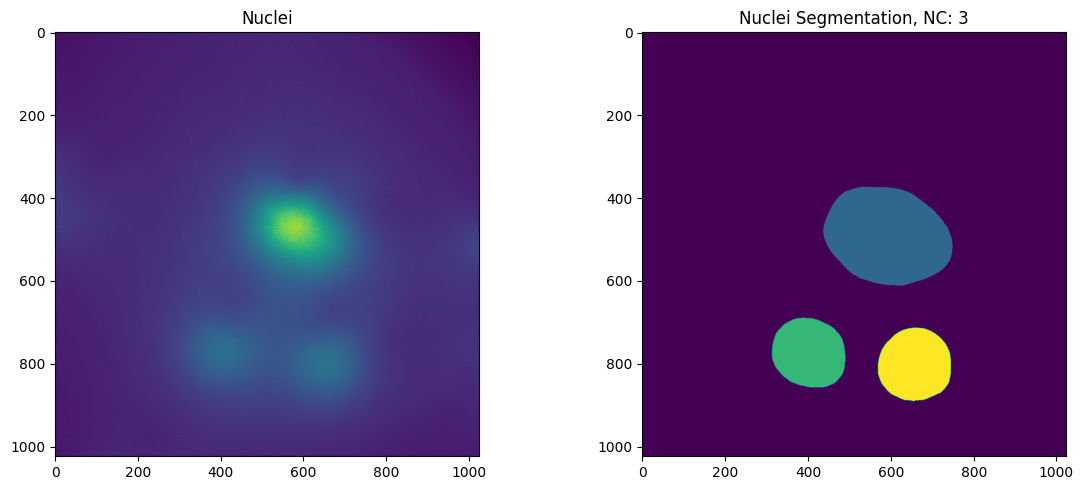

INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>> cyto3 << model set to be used


Segmenting Nuclei


INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [0, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.85 sec


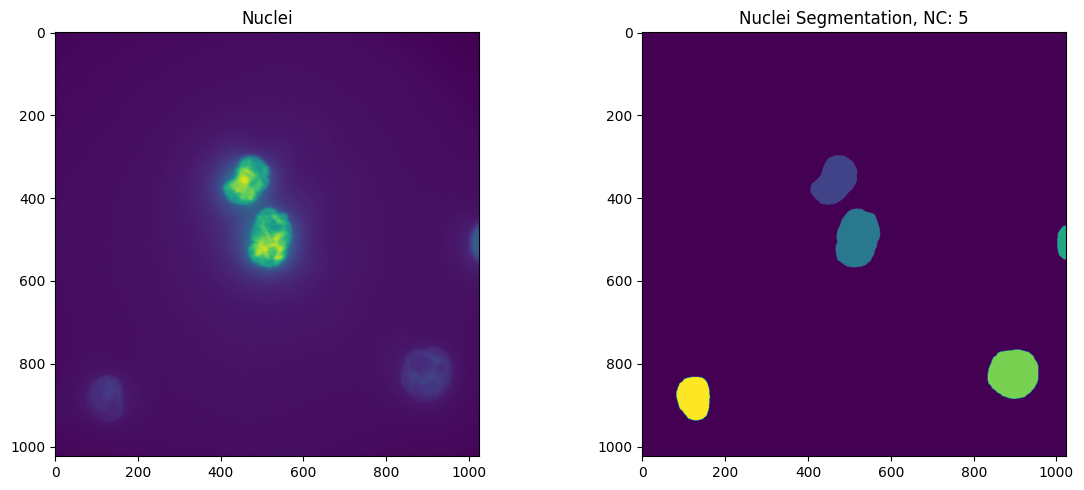

In [4]:
data.nuc_masks = da.zeros([pp, tt, yy, xx])
params.nucChannel = 2


count = 0
for p in range(pp):
    for t in range(tt):
        if count >= params.num_chunks_to_run:
            break
        kwargs = {**params.__dict__, **data.__dict__}
        kwargs['image'] = data.images[p, t]
        kwargs['fov'] = p
        kwargs['timepoint'] = t
        output = SimpleCellposeSegmentaion().main(**kwargs)
        data.nuc_masks[p,t] = output['nuc_mask']
        count += 1



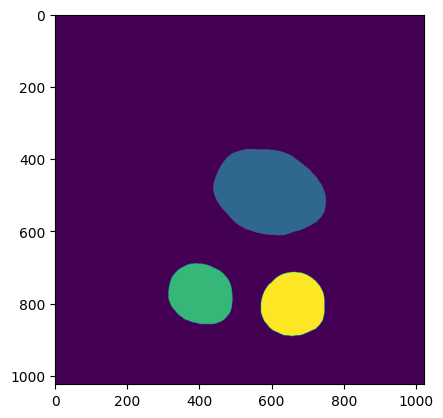

In [5]:
plt.imshow(data.nuc_masks[0, 0, :, :])
plt.show()

Detecting Spots


c:\Users\Jack\Documents\GitHub\AngelFISH\Demos\..\source\Steps\SpotDetection_Steps.py:323: RuntimeWarning: overflow encountered in scalar negative
  spot_background[:, edge_background_yx:-edge_background_yx, edge_background_yx:-edge_background_yx] = -1


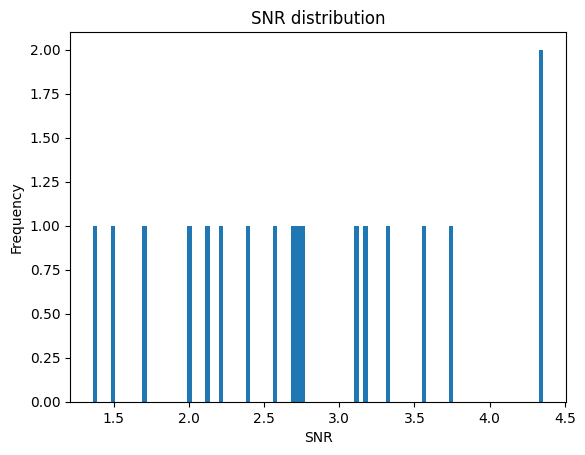

median SNR: 2.7112801320573263
mean SNR: 2.7608263154084876


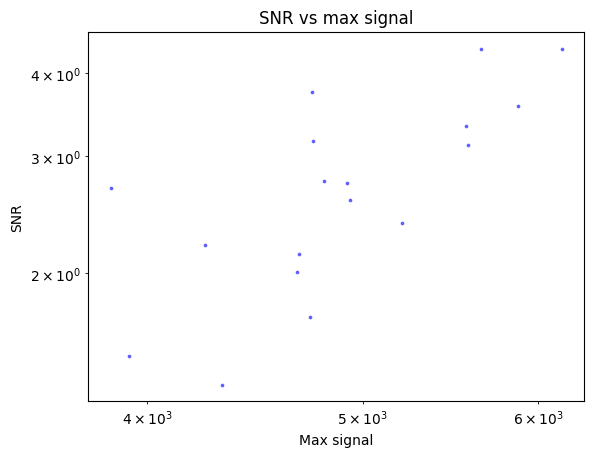

SNR threshold: None


c:\Users\Jack\Documents\GitHub\AngelFISH\.venv\Lib\site-packages\bigfish\detection\utils.py:321: UserWarning: Problem occurs during the computation of a reference spot. Not enough (uncropped) spots have been detected.
  warnings.warn("Problem occurs during the computation of a reference "


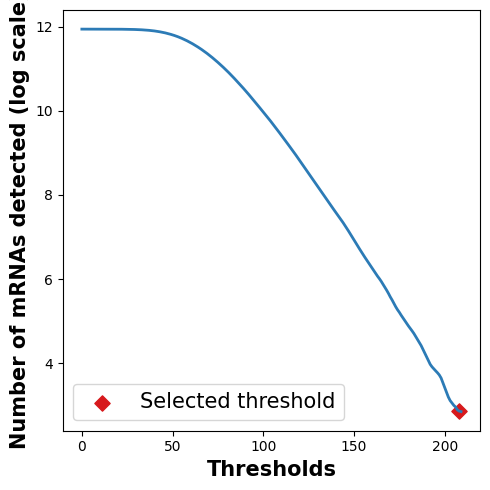

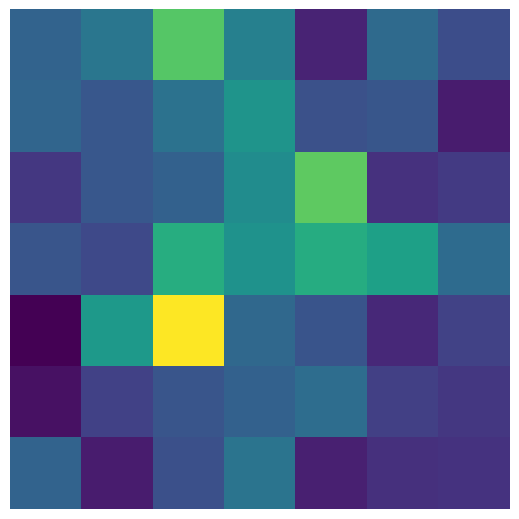

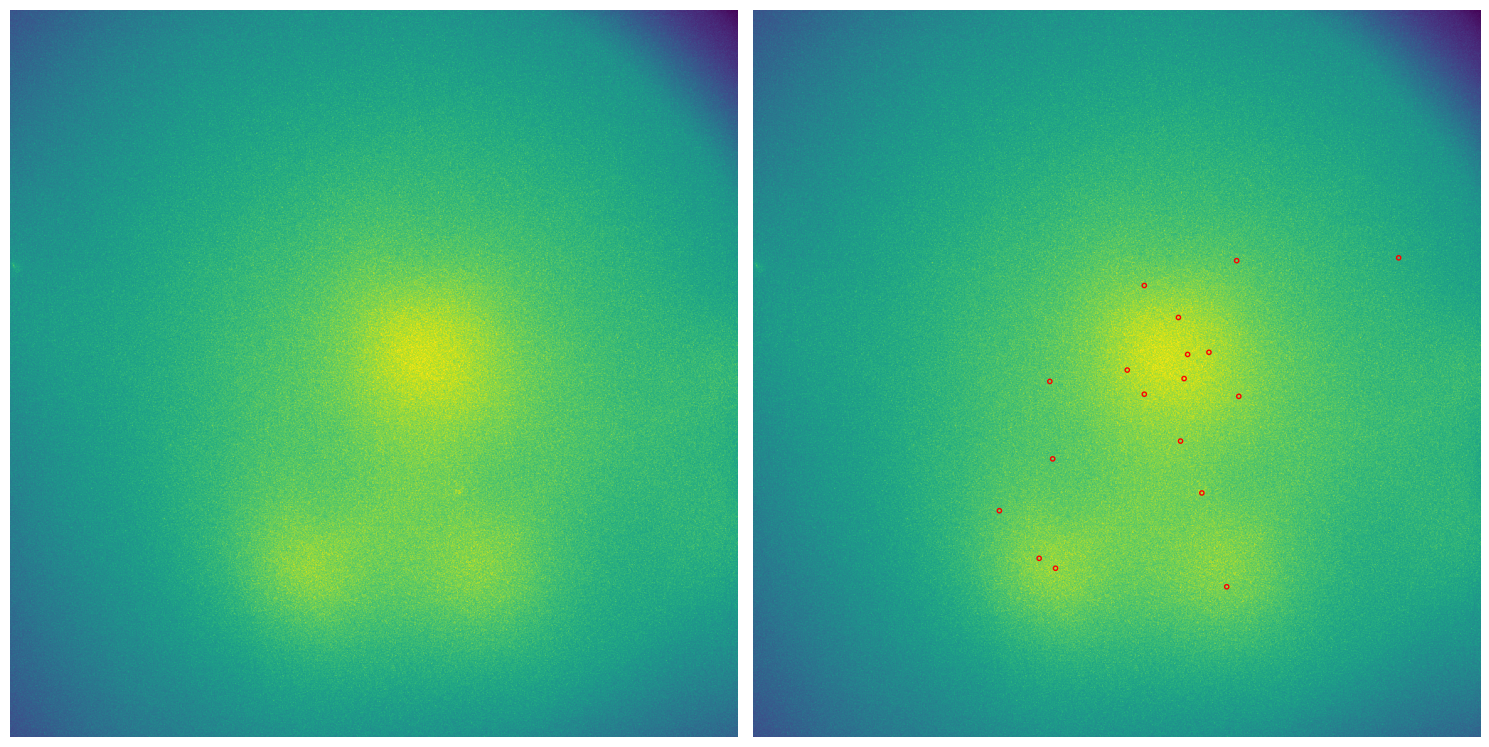

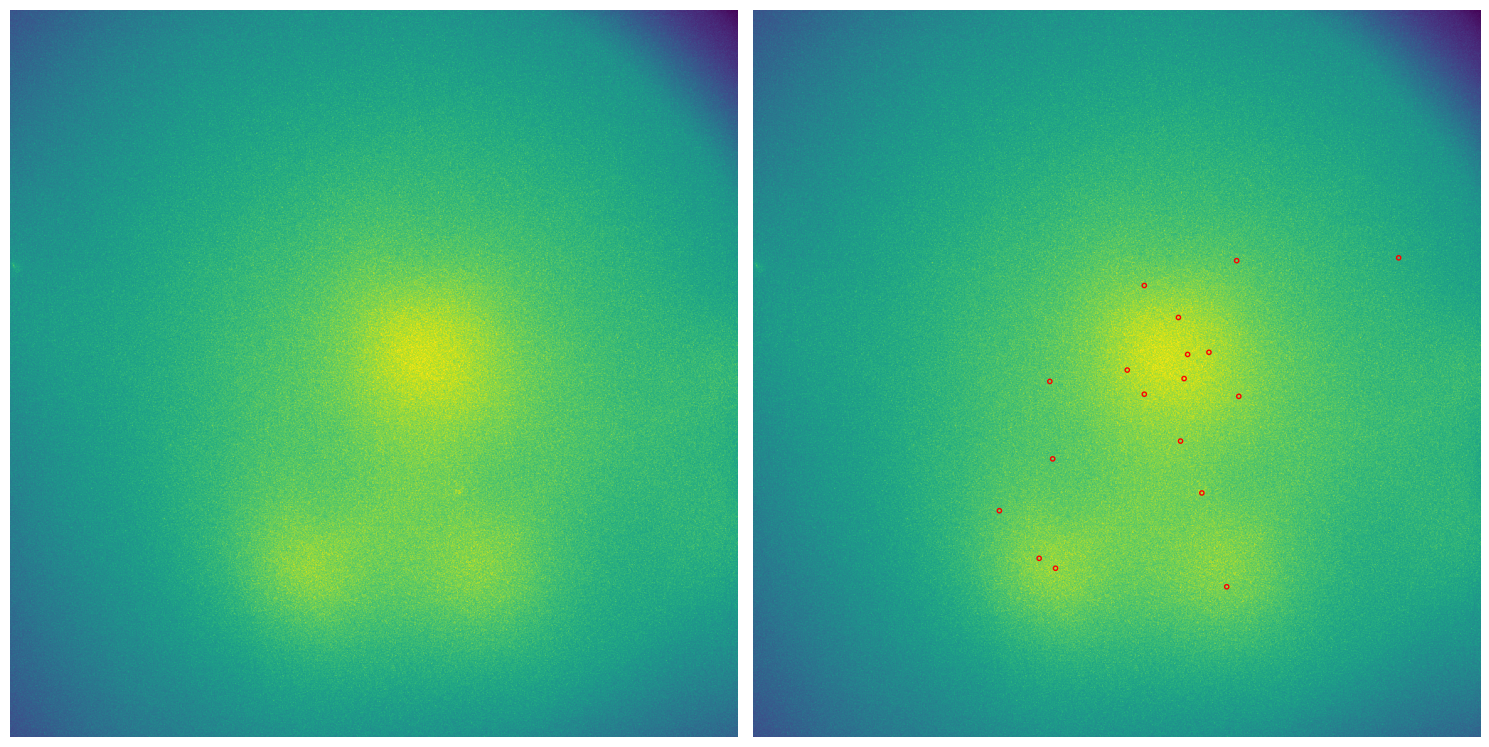

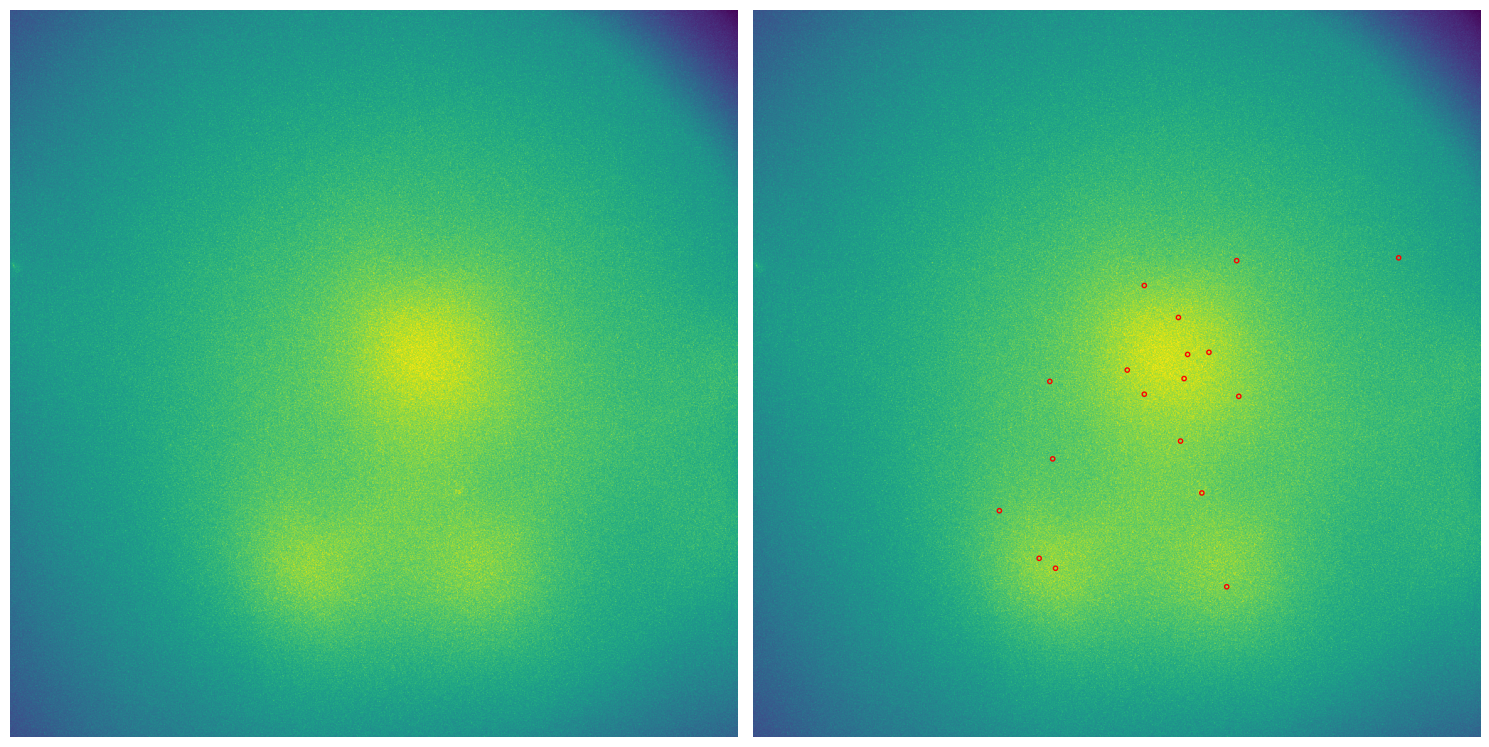

Extracting Cell Results from masks


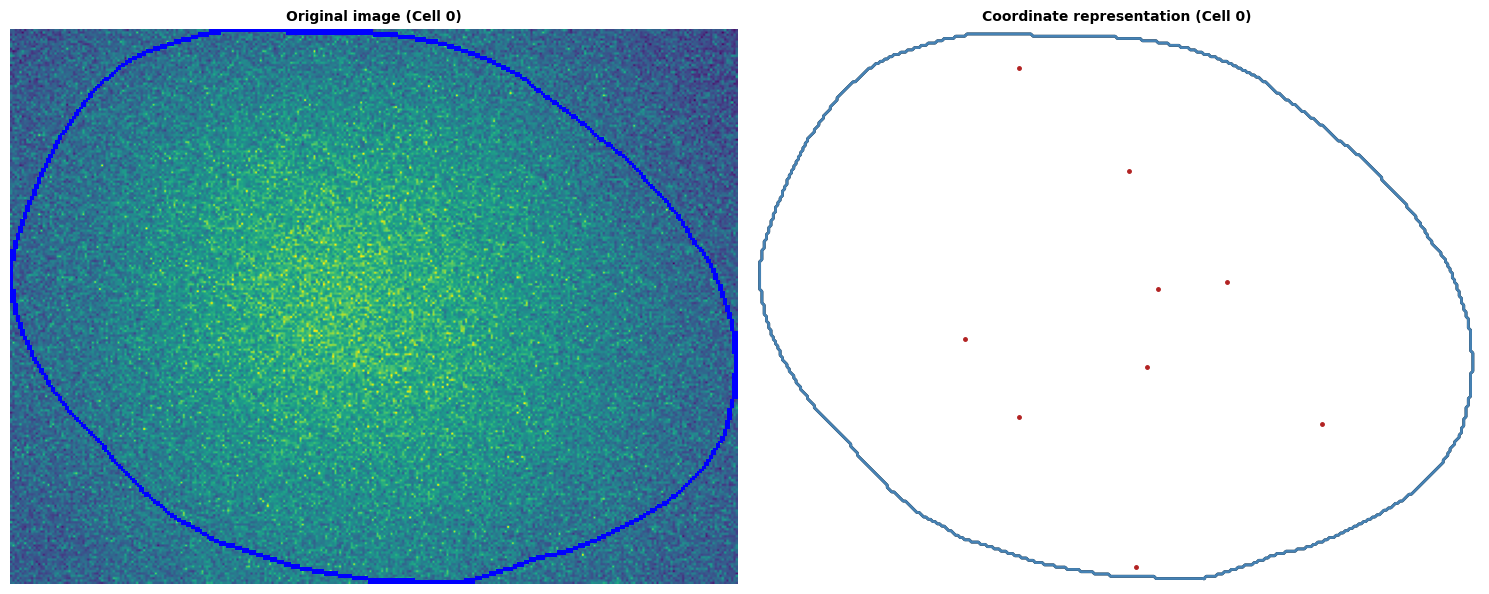

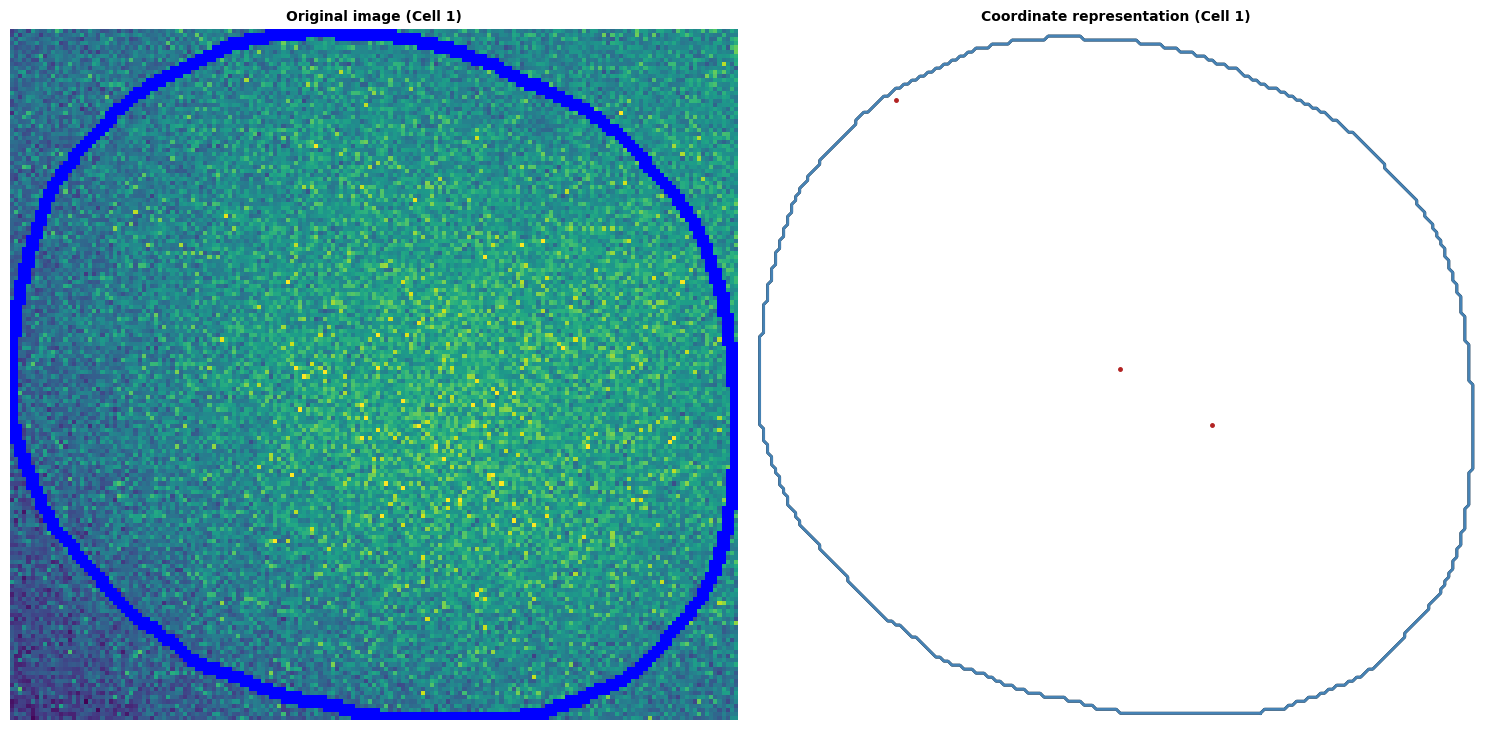

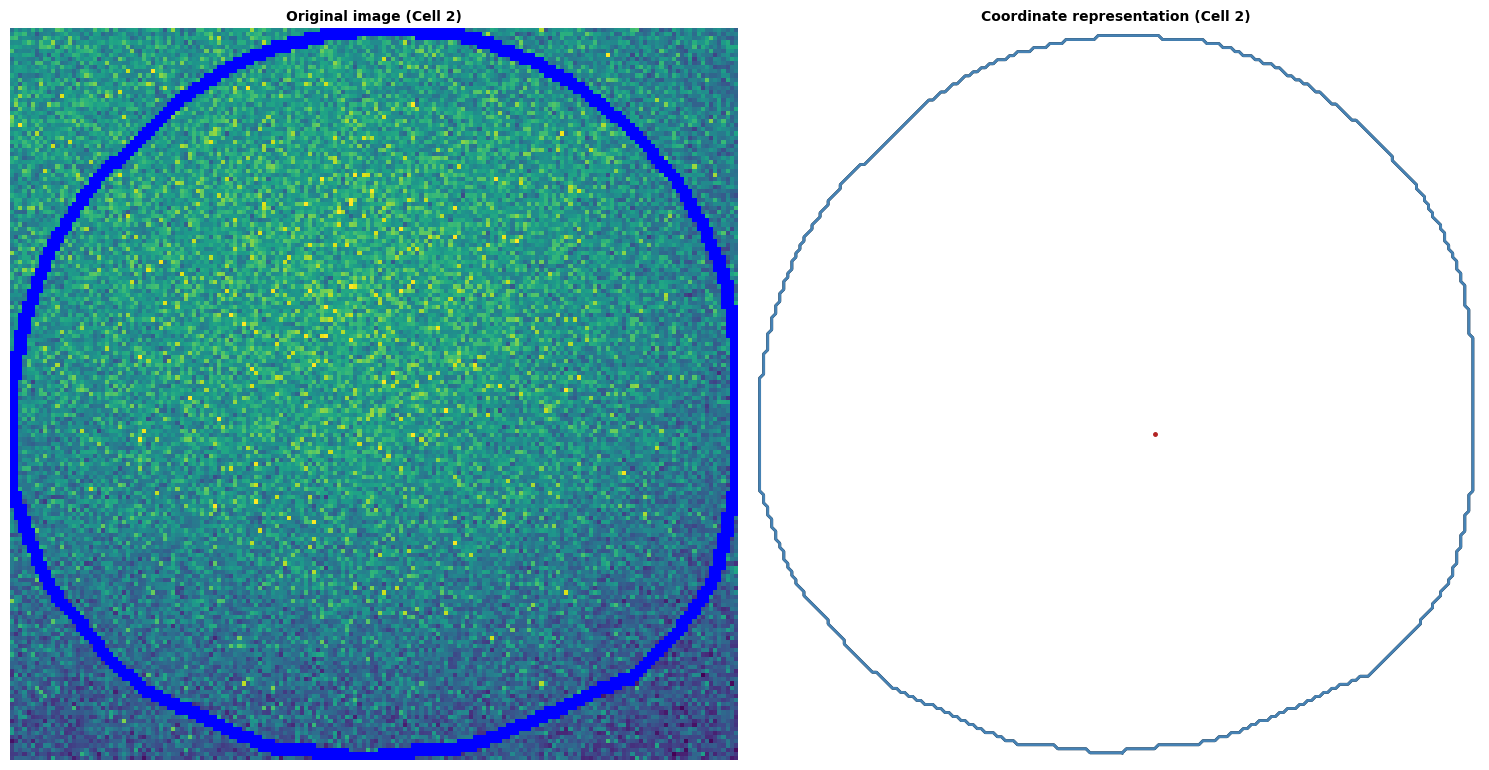

Computing Spot Properties
Standardizing Data
Complete Spot Detection


c:\Users\Jack\Documents\GitHub\AngelFISH\Demos\..\source\Steps\SpotDetection_Steps.py:323: RuntimeWarning: overflow encountered in scalar negative
  spot_background[:, edge_background_yx:-edge_background_yx, edge_background_yx:-edge_background_yx] = -1


Detecting Spots


c:\Users\Jack\Documents\GitHub\AngelFISH\Demos\..\source\Steps\SpotDetection_Steps.py:323: RuntimeWarning: overflow encountered in scalar negative
  spot_background[:, edge_background_yx:-edge_background_yx, edge_background_yx:-edge_background_yx] = -1


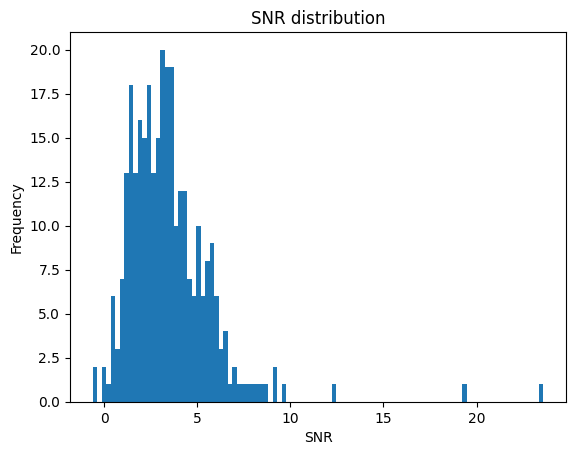

median SNR: 3.1669558655233816
mean SNR: 3.464559293488346


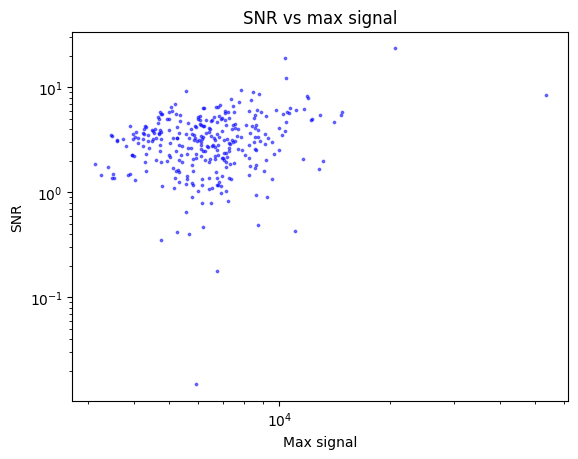

SNR threshold: None


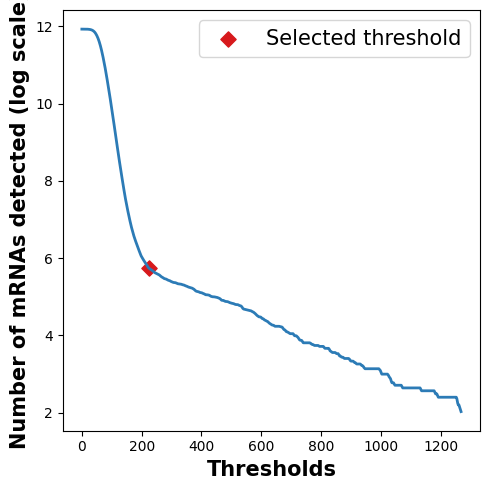

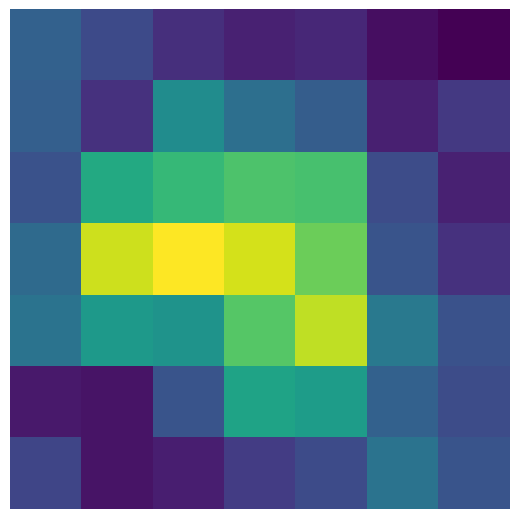

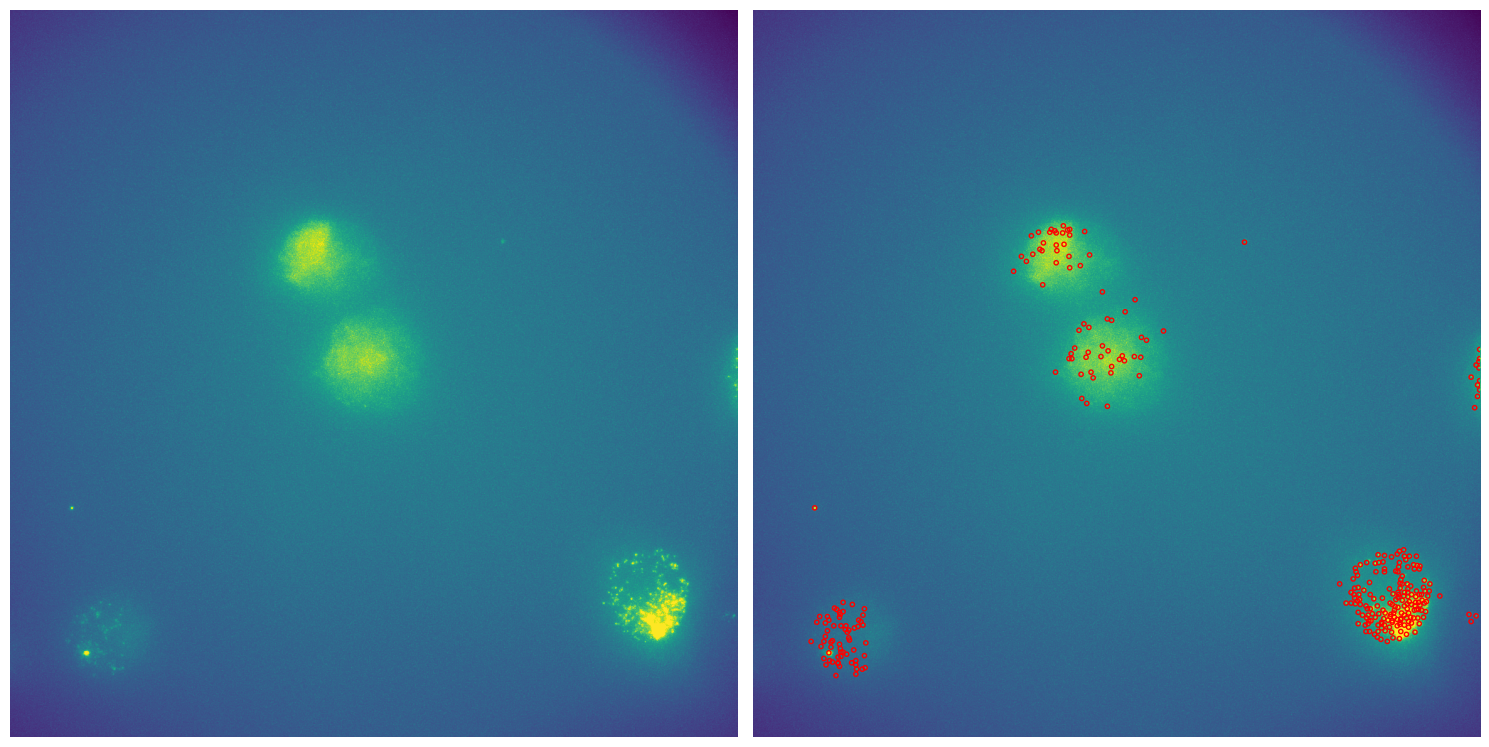

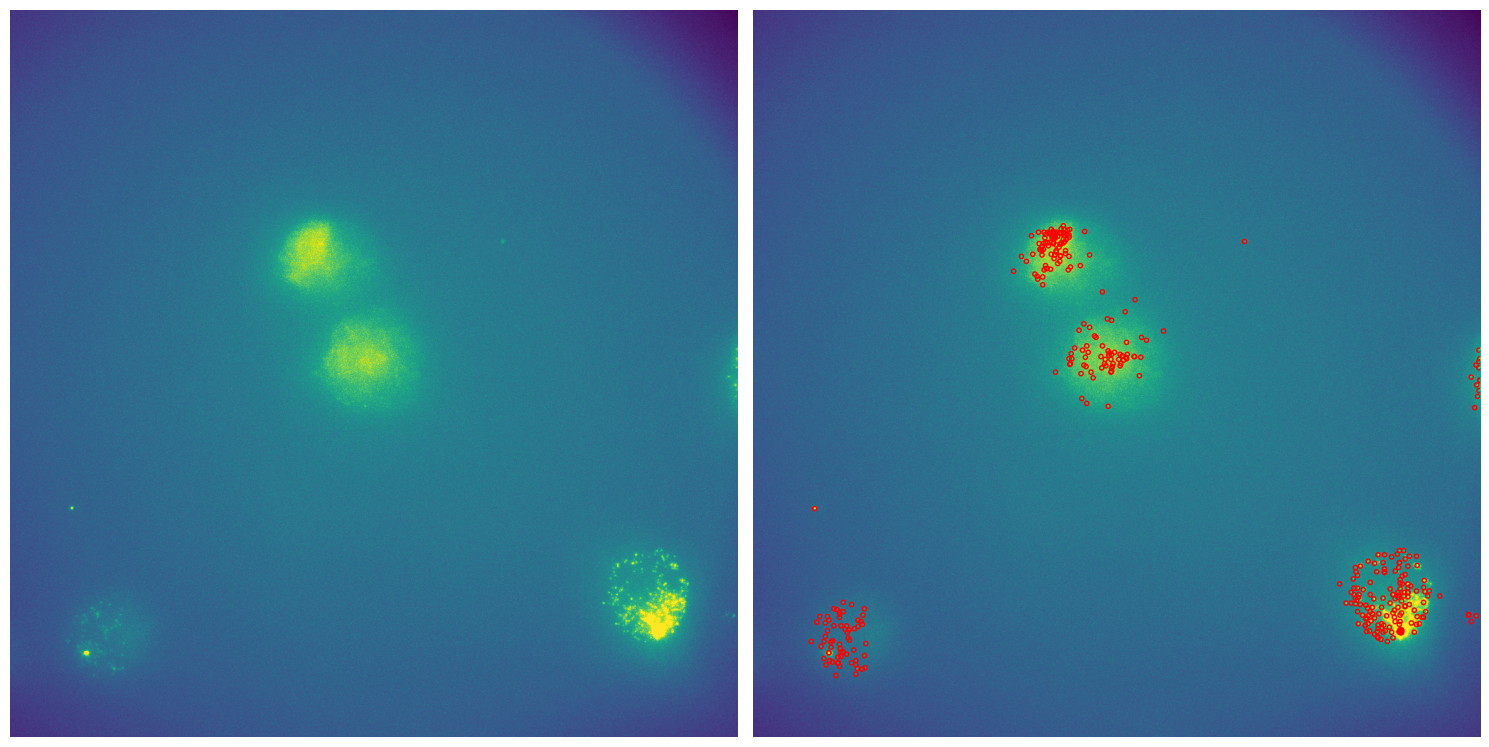

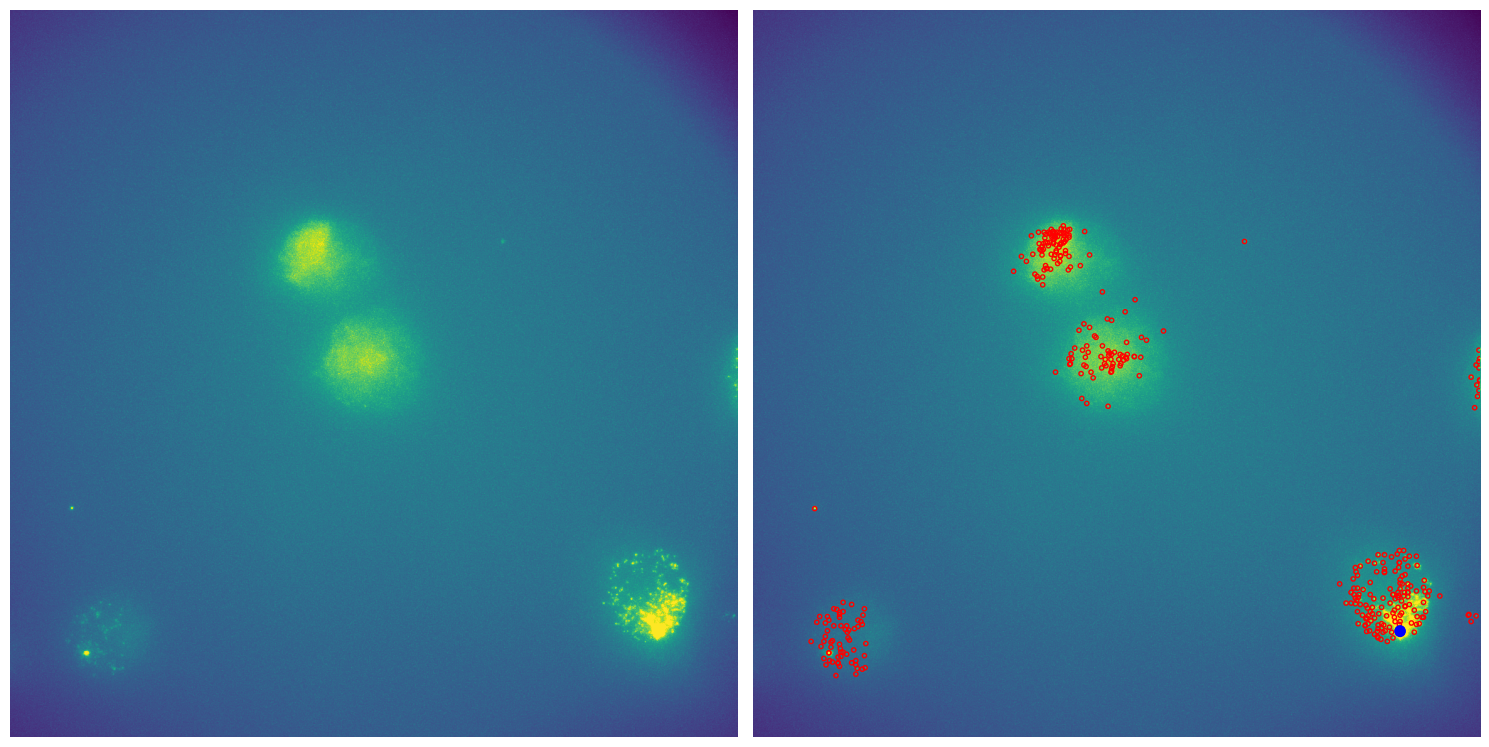

Extracting Cell Results from masks
Computing Spot Properties
Standardizing Data
Complete Spot Detection


c:\Users\Jack\Documents\GitHub\AngelFISH\Demos\..\source\Steps\SpotDetection_Steps.py:323: RuntimeWarning: overflow encountered in scalar negative
  spot_background[:, edge_background_yx:-edge_background_yx, edge_background_yx:-edge_background_yx] = -1


In [6]:
params.FISHChannel = [0]
params.bigfish_alpha = 0.99
params.bigfish_beta = 1
params.bigfish_gamma = 5
params.voxel_size_yx = 130
params.voxel_size_z = 500
params.spot_yx = 160
params.spot_z = 1000

count = 0
for p in range(pp):
    for t in range(tt):
        if count >= params.num_chunks_to_run:
            break
        kwargs = {**params.__dict__, **data.__dict__}
        kwargs['image'] = data.images[p, t]
        if data.nuc_masks is not None:
            kwargs['nuc_mask'] = np.array(data.nuc_masks[p,t])
        if data.cell_masks is not None:
            kwargs['cell_mask'] = np.array(data.cell_masks[p, t])
        kwargs['fov'] = p
        kwargs['timepoint'] = t
        output = BIGFISH_SpotDetection().main(**kwargs)
        data.append(output)
        count += 1


In [7]:
count = 0
for p in range(pp):
    for t in range(tt):
        if count >= params.num_chunks_to_run:
            break
        kwargs = {**params.__dict__, **data.__dict__}
        kwargs['image'] = data.images[p, t]
        if data.nuc_masks is not None:
            kwargs['nuc_mask'] = data.nuc_masks[p, t, :, :]
            kwargs['nuc_mask'] = kwargs['nuc_mask'][np.newaxis, :, :]

        if data.cell_masks is not None:
            kwargs['cell_mask'] = data.cell_masks[p, t, :, :]
            kwargs['cell_mask'] = kwargs['cell_masks'][np.newaxis, :, :]
            
        kwargs['fov'] = p
        kwargs['timepoint'] = t
        output = CellProperties().main(**kwargs)
        data.append(output)
        count += 1

In [8]:
# Save_Images().main(**{**params.__dict__, **data.__dict__})

Save_Masks().main(**{**params.__dict__, **data.__dict__, 
                    'masks':{'nuc_masks': data.nuc_masks}})

Save_Parameters().main(params, **{**params.__dict__, **data.__dict__})

Save_Outputs().main(data.__dict__, **{**params.__dict__, 'position_indexs': data.position_indexs})


TypeError: 'NoneType' object is not subscriptable

In [ ]:
return_to_NAS().main(**params.__dict__)

In [ ]:
print(params)
print(data)